In [6]:
import helpers as hlp
import numpy as np
import numpy as np
import helpers as hlp
import math
from random import random, seed
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from tqdm import tqdm
from scipy.stats import multivariate_normal


In [2]:
extracted_coefficients_path = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_path + 'Bzeta/B_zeta.npy')
#beta_path = str(extracted_coefficients_path + 'beta/beta.csv')
z_path = str(extracted_coefficients_path + 'Bzeta/tr_labels.npy')

beta = np.genfromtxt(beta_path, delimiter=',')
# B_zeta is a n x q matrix
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
tBB = B_zeta.T.dot(B_zeta)
z = np.load(z_path) #[0:B_zeta.shape[0]]

# p is the number of beta coefficients in the last hidden layer
p = B_zeta.shape[1]


# Lambda is a diagonal matrix of dimension p
Lambda = np.diag(np.random.rand(p,))

seed(679305)
tau_start = 0.01

# Set iteration counter to 0
t = 0

theta = 2.5

n = B_zeta.shape[0]

# S(x, theta) is of dimension n x n
W = np.array([B_zeta[i,:].dot(B_zeta[i,:]) for i in range(0, n)])
S = np.sqrt(1/(1 + W*tau_start))
S2 = S**2

# m is number of variational parameters, which is 
# 2p (for each lambda_j and each beta_j)
# plus the variational parameter for the prior on lambda
m = p + 1

# number of factors in the factored covariance representation
k = 3

mu_t = np.array([random() for i in range(0,m)]).reshape(m,1)
# B is a lower triangle m x k matrix and is the first component of the 
# covariance matrix
B_t = np.tril(np.random.rand(m,k))
while not np.linalg.matrix_rank(B_t) == k:
    B_t = np.tril(np.random.rand(m,k))

# D is a diagonal matrix of dimension m x m and is the second component of the 
# covariance matrix
D_t = np.diag(np.repeat(1,m))
d_t = np.diag(D_t).reshape(m,1)

mean_epsilon = np.repeat(0, m)
mean_z = np.repeat(0, k)

var_epsilon = np.diag(np.repeat(1,m))
var_z = np.diag(np.repeat(1,k))

## Adadelta
decay_rate = 0.95
constant = 1e-7
E_g2_t_1 = 0
E_delta_x_2_1 = 0

E_g2_t_1_mu = np.repeat(0, len(mu_t))
E_delta_x_2_1_mu = np.repeat(0, len(mu_t))
E_g2_t_1_B = np.zeros(B_t.shape)
E_delta_x_2_1_B = np.zeros(B_t.shape)
E_g2_t_1_d = np.repeat(0, len(d_t)).reshape(m,1)
E_delta_x_2_1_d = np.repeat(0, len(d_t)).reshape(m,1)

def adadelta_change(gradient, E_g2_t_1, E_delta_x_2_1, decay_rate = 0.99, constant = 10e-6):
    # expected squared gradient for next iteration
    E_g2_t = decay_rate*E_g2_t_1 + (1 - decay_rate)*(gradient**2)
    # update for parameter
    # should there be a minus or plus here ?????
    delta_x =  (np.sqrt(E_delta_x_2_1 + constant)/np.sqrt(E_g2_t + constant))*gradient
    # expected update for next iteration
    E_delta_x_2 = decay_rate*E_delta_x_2_1 + (1 - decay_rate)*(delta_x**2)
    return(delta_x, E_g2_t, E_delta_x_2 )

lower_bounds = []
all_varthetas = []
d_ts = []
mu_ts = []
d_ts = []
B_ts = []
t = 0

n = 50
iterations = 10000
for i in tqdm(range(iterations)):
    
    # 1. Generate epsilon_t and z_t
    z_t = hlp.generate_z(mean_z,var_z, n)
    epsilon_t = hlp.generate_epsilon(mean_epsilon, var_epsilon, n)
    
    # 2. Draw from vartheta, what we generate are log values
    # of lambda and tau -> have to transform them back to use them

    
    # Compute inverse with Woodbury formula.
    inv = np.diag(1/(np.diag(D_t**2)))
    inv2 = np.linalg.inv(np.identity(k) + B_t.T.dot(inv).dot(B_t))
    BBD_inv = inv - multi_dot([inv, B_t, inv2, B_t.T, inv])

    for i in range(0, n):
        
        z_t_i = z_t[i,:].reshape(k,1)
        epsilon_t_i = epsilon_t[i,:].reshape(11,1)
        vartheta_t = mu_t + B_t.dot(z_t_i) +  (d_t*epsilon_t_i)
        beta_t = vartheta_t[0:p].reshape(p,)
        betaBt_t = beta_t.dot(B_zeta.T)
    
        # 3. Compute gradient of beta, lambda_j, and tau
        gradient_h_t = hlp.Delta_theta(vartheta_t, B_zeta, n, z, p, tBB, betaBt_t, theta, W)

        # Compute gradients for the variational parameters mu, B, D
        Delta_mu = hlp.Delta_mu(gradient_h_t, BBD_inv, z_t_i, d_t, epsilon_t_i, B_t)
        Delta_B = hlp.Delta_B(B_zeta,n,z, p, B_t, gradient_h_t, z_t_i, D_t, d_t, epsilon_t_i, BBD_inv)
        Delta_D = hlp.Delta_D(gradient_h_t, epsilon_t_i, D_t, d_t,p, BBD_inv, z_t_i, B_t).reshape(11,1)
        
        if i == 0:
            Delta_mu_mean = Delta_mu/n
            Delta_B_mean = Delta_B/n
            Delta_D_mean = Delta_D/n
        elif i > 0:
            Delta_mu_mean += Delta_mu/n
            Delta_B_mean += Delta_B/n
            Delta_D_mean += Delta_D/n  
    
    # 4. Adadelta Updates
    update_mu, E_g2_t_1_mu, E_delta_x_2_1_mu = adadelta_change(Delta_mu_mean, E_g2_t_1_mu, E_delta_x_2_1_mu, decay_rate = decay_rate, constant = constant)
    update_B, E_g2_t_1_B, E_delta_x_2_1_B  = adadelta_change(Delta_B_mean, E_g2_t_1_B, E_delta_x_2_1_B, decay_rate = decay_rate, constant = constant)
    update_d, E_g2_t_1_d, E_delta_x_2_1_d = adadelta_change(Delta_D_mean, E_g2_t_1_d, E_delta_x_2_1_d, decay_rate = decay_rate, constant = constant)
    
    # Update variables
    mu_t = mu_t + update_mu.reshape(m,1)
    B_t = B_t + update_B
    # set upper triangular elements to 0
    B_t *= np.tri(*B_t.shape)
    d_t = (d_t + update_d)
    D_t = np.diag(d_t.reshape(m,))
    
    for i in range(0, n):
        z_t_i = z_t[i,:].reshape(k,1)
        epsilon_t_i = epsilon_t[i,:].reshape(11,1)
        vartheta_t = mu_t + B_t.dot(z_t_i) +  (d_t*epsilon_t_i)
        vartheta_t_transf = vartheta_t.copy()

        # 5. compute stopping criterion
        beta_t = vartheta_t_transf[0:p].reshape(p,)
        u_t = vartheta_t_transf[p]
        betaBt_t = beta_t.dot(B_zeta.T) 

        S = np.sqrt(1/(1 + W*np.exp(u_t)))
        S2 = S**2

        # Lower bound L(lambda) = E[log(L_lambda - q_lambda]
        log_h_t = hlp.log_density(z, u_t,  beta_t, B_zeta, p, n, S, S2, tBB, theta, betaBt_t)
        log_q_lambda_t = np.log(multivariate_normal.pdf(vartheta_t.reshape(11,), mu_t.reshape(11), (B_t.dot(B_t.T) + D_t**2)))
        
        if i == 0:
            L_lambda_mean = (log_h_t - log_q_lambda_t)/n
        elif i > 0:
            L_lambda_mean += (log_h_t - log_q_lambda_t)/n
    
    # evidence lower bound
    lower_bounds.append(L_lambda_mean.item())
    all_varthetas.append(vartheta_t)
    mu_ts.append(mu_t)
    d_ts.append(d_t)
    B_ts.append(B_t)
    
    # increase time count
    t = t+1

np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/lower_bounds_factor_4_50.npy', lower_bounds)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/vartheta_factor_4_50.npy', np.array(all_varthetas))
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/mu_ts23_factor_4_50.npy', mu_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/d_ts23_factor_4_50.npy', d_ts)
np.save('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/B_ts23_factor_4_50.npy', B_ts)

100%|██████████| 10000/10000 [12:29:14<00:00,  4.50s/it] 


In [13]:
lower_bounds = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/lower_bounds_factor_4_50.npy')
all_varthetas = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/vartheta_factor_4_50.npy')
mu_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/mu_ts23_factor_4_50.npy')
d_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/d_ts23_factor_4_50.npy')
B_ts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Ridge/B_ts23_factor_4_50.npy')

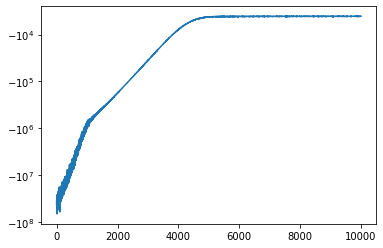

In [14]:
plt.plot(lower_bounds)
plt.yscale('symlog')

In [15]:
B_ts_m = np.mean(np.array(B_ts)[9800:,:,:], axis = 0)
d_ts_m = np.mean(np.array(d_ts)[9800:,:,:], axis = 0)
mu_ts_m = np.mean(np.array(mu_ts)[9800:,:,:], axis = 0)

In [16]:
d_ts_m.reshape(11,)

array([-2.81356460e-03, -1.30801139e-02, -1.85386900e-04,  1.30828515e-02,
        2.72533677e-05,  1.19622024e-02, -2.38516794e-03,  1.04413821e-02,
        1.07065043e-04,  8.23453763e-03, -1.37274652e-02])

In [17]:
var_va = np.sqrt(np.diag(B_ts_m.dot(B_ts_m.T) + np.diag(d_ts_m**2)))

In [18]:
var_va

array([0.01506274, 0.01438988, 0.03329522, 0.02362545, 0.01964436,
       0.02020174, 0.01852237, 0.02890086, 0.03955106, 0.0405876 ,
       0.00366521])

In [25]:
all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas_L100_3000.npy')

In [26]:
mcmc_mean = np.mean(all_thetas[100:,:], axis = 0)
mcmc_sd = np.std(all_thetas[100:,:], axis = 0)

(-1.0, 1.0)

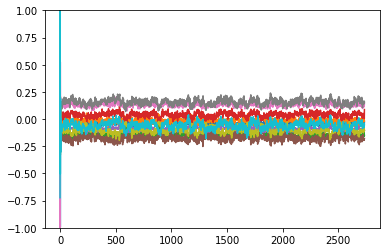

In [27]:
plt.plot(all_thetas)
plt.ylim(-1,1)

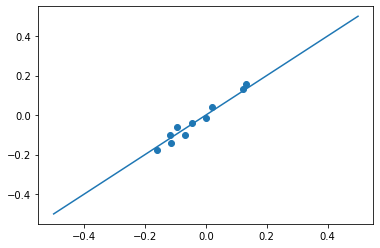

In [28]:
plt.scatter(mu_ts_m[0:10], mcmc_mean[0:10])
ident = [-.5, .5]
plt.plot(ident,ident)

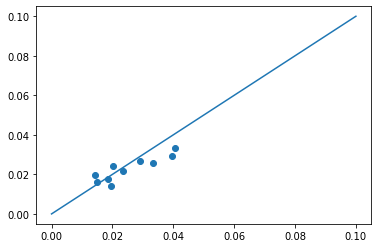

In [29]:
plt.scatter(var_va[0:10], mcmc_sd[0:10])
#plt.scatter(np.exp(var_va[10]), np.exp(mcmc_sd[10]))
ident = [0, 0.1]
plt.plot(ident,ident)